In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from tradealgorithm.tradealgorithm import TradeAlgorithm
from tradealgorithm.tradealgorithmfactory import TradeAlgorithmFactory
from pricer.pricer_factory import PricerFactory
from pricer.pricer import Pricer
from ranker.ranker_factory import RankerFactory
from ranker.ranker import Ranker
from classifier.classifier_factory import ClassifierFactory
from classifier.classifier import Classifier
from datetime import datetime

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
start = datetime(2001,1,1)
end  = datetime(2023,1,1)
current_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
pricer_classes = [] 
pricer_classes.append(Pricer.WEEKLY_STOCK_ROLLING)
pricer_classes.append(Pricer.WEEKLY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_ROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_MEANREVERSION)
pricer_classes.append(Pricer.DAILY_STOCK_DEVROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_BREAKOUT)

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields10"),10)
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()
current = False
ranker_class = Ranker.NONE
classifier_class = Classifier.NONE

In [7]:
analysis = []
trade_algos = []
for pricer_class in tqdm(pricer_classes):
    trade_algo = TradeAlgorithmFactory.build(TradeAlgorithm.RRR_BETA)
    trade_algo.initialize(pricer_class,ranker_class,classifier_class,start,end,current_date)
    trade_algo.initialize_bench_and_yields()
    trade_algo.initialize_classes()
    trade_algos.append(trade_algo)
    trade_algo.db.connect()
    parameters = trade_algo.pull_iterations().to_dict("records")
    for parameter in tqdm(parameters):
        try:
            trade = trade_algo.db.query("trades",{"iteration":parameter["iteration"]})
            if trade.index.size > 0:
                positions = int(trade_algo.positions) if trade_algo.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  trade_algo.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                anas = trade_algo.analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["trade_algo"] = trade_algo.name
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    analysis.append(cumulative[list(parameter.keys()) + ["trade_algo","pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    trade_algo.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


In [8]:
trade

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,iteration
0,2001,2001-01-29,GLW,0.229636,1.0,1.005714,0,2
1,2001,2001-01-30,NTAP,0.227227,1.0,0.922587,0,2
2,2001,2001-01-31,REGN,0.207480,1.0,1.003969,0,2
3,2001,2001-02-01,ADBE,0.306020,1.0,0.958627,0,2
4,2001,2001-02-02,ADBE,0.277729,1.0,1.041781,0,2
...,...,...,...,...,...,...,...,...
103426,2023,2023-07-21,ALB,0.054502,1.0,0.975971,19,2
103427,2023,2023-07-24,RHI,0.060275,1.0,1.001498,19,2
103428,2023,2023-07-25,LVS,0.061383,1.0,1.021273,19,2
103429,2023,2023-07-26,LUMN,0.067797,1.0,0.944751,19,2


In [9]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,trade_algo,pv,beta,rrr,sharpe
1,True,False,False,False,rrr,1,tyield1,1,1,dsw_n_n_b_r,857.448902,-0.037610,0.972854,-22771.906597
2,True,False,False,False,none,1,tyield1,1,2,dsw_n_n_b_r,819.492256,-0.030990,0.977612,-26411.874340
0,True,False,False,False,flat,1,tyield1,1,0,dsw_n_n_b_r,736.793457,-0.036833,0.973368,-19976.399575


In [10]:
top_by_strategy = a.sort_values("pv",ascending=False).groupby("trade_algo").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,pv,beta,rrr,sharpe
0,dsw_n_n_b_r,True,False,False,False,rrr,1,tyield1,1,1,857.448902,-0.03761,0.972854,-22771.906597


In [11]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["trade_algo"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()
    db.cloud_connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [12]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["trade_algo"])
db.connect()
analysis = db.query("trades",{"iteration":int(top["iteration"])})
db.disconnect()

In [13]:
trade_algo_name = top["trade_algo"]
trade_algo_class = [x for x in trade_algos if x.name == trade_algo_name][0]
anas = trade_algo_class.analysis
naming = trade_algo_class.pricer_class.time_horizon_class.naming_convention
positions = int(int(analysis["position"].max()))
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[(ledger["year"]>=start.year)]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [14]:
ledger

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-29,GLW,0.229636,1.0,1.005714,0,Information Technology,Corning Inc.
1,2001,2001-01-30,GLW,0.212121,1.0,0.976412,0,Information Technology,Corning Inc.
2,2001,2001-01-31,REGN,0.207480,1.0,1.003969,0,Health Care,Regeneron
3,2001,2001-02-01,TRMB,0.195264,1.0,0.974476,0,Information Technology,Trimble Inc.
4,2001,2001-02-02,NTAP,0.213488,1.0,0.926417,0,Information Technology,NetApp
...,...,...,...,...,...,...,...,...,...
99709,2023,2023-07-21,GOOGL,0.052181,1.0,1.012581,19,Communication Services,Alphabet Inc. (Class A)
99710,2023,2023-07-24,META,0.055597,1.0,1.009808,19,Communication Services,Meta Platforms
99711,2023,2023-07-25,NXPI,0.060603,1.0,0.993588,19,Information Technology,NXP Semiconductors
99712,2023,2023-07-26,SBAC,0.063703,1.0,0.982332,19,Real Estate,SBA Communications


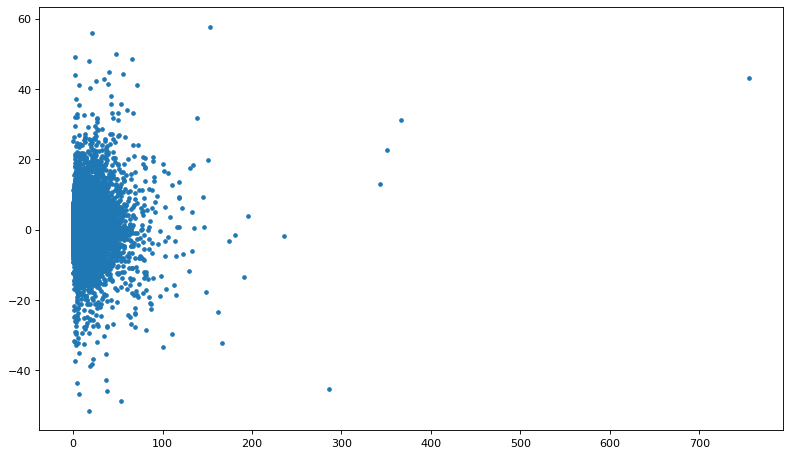

In [15]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [16]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(40)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-29,GLW,0.229636,1.0,1.005714,0,Information Technology,Corning Inc.
5185,2001,2001-01-29,TXN,0.170120,1.0,1.017747,1,Information Technology,Texas Instruments
10361,2001,2001-01-29,MCD,0.155172,1.0,0.997629,2,Consumer Discretionary,McDonald's
15523,2001,2001-01-29,CDNS,0.146151,1.0,1.045981,3,Information Technology,Cadence Design Systems
20667,2001,2001-01-29,IDXX,0.135441,1.0,1.028966,4,Health Care,Idexx Laboratories
25799,2001,2001-01-29,PTC,0.124828,1.0,0.953846,5,Information Technology,PTC
30913,2001,2001-01-29,ORLY,0.116604,1.0,1.000000,6,Consumer Discretionary,O'Reilly Auto Parts
36008,2001,2001-01-29,TROW,0.112857,1.0,0.987383,7,Financials,T. Rowe Price
41080,2001,2001-01-29,ROL,0.085359,1.0,1.002950,8,Industrials,"Rollins, Inc."
46131,2001,2001-01-29,HAS,0.076522,1.0,1.010118,9,Consumer Discretionary,Hasbro


In [17]:
ledger[ledger["position"]<20].sort_values("actual_returns",ascending=False).head(50)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
1810,2008,2008-10-31,HIG,1.525988,1.0,1.577519,0,Financials,Hartford (The)
15571,2001,2001-04-06,EQIX,0.213592,1.0,1.559322,3,Real Estate,Equinix
6980,2008,2008-10-13,HBAN,0.474966,1.0,1.500741,1,Financials,Huntington National Bank
46939,2004,2004-08-02,CMCSA,0.025912,1.0,1.490606,9,Communication Services,Comcast
7036,2009,2009-02-05,RF,0.656000,1.0,1.484099,1,Financials,Regions Financial Corporation
37876,2009,2009-04-02,MGM,0.174905,1.0,1.480892,7,Consumer Discretionary,MGM Resorts
32729,2008,2008-11-21,CBRE,0.398844,1.0,1.449857,6,Real Estate,CBRE Group
9595,2020,2020-03-23,CZR,0.562358,1.0,1.441571,1,Consumer Discretionary,Caesars Entertainment
89731,2020,2020-11-03,BIIB,0.025342,1.0,1.439739,17,Health Care,Biogen
1779,2008,2008-09-18,AIG,7.560976,1.0,1.431227,0,Financials,American International Group


In [18]:
ledger["actual_returns"].mean()

1.0012340143515608

In [19]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5137894377920854

In [20]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [21]:
portfolio.head(20)

position,year,date,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2001,2001-01-29,1.005714,1.017747,0.997629,1.045981,1.028966,0.953846,1.000000,0.987383,...,0.968131,1.008997,0.972808,0.981132,1.026946,1.031250,0.976665,0.988366,1.062222,0.994098
1,2001,2001-01-30,0.976412,0.942171,0.991510,0.989597,0.888325,0.996604,0.985545,1.104603,...,1.000751,1.038235,0.992941,1.006889,0.994142,0.965000,1.043949,0.996789,1.019168,1.010408
2,2001,2001-01-31,1.003969,0.961030,1.022663,0.938764,0.950791,1.021635,1.023524,0.964015,...,0.975712,1.025971,1.033333,0.986251,0.996601,1.025180,0.868171,0.993984,0.991667,1.028406
3,2001,2001-02-01,0.974476,0.929825,0.955307,0.983210,0.982664,1.053046,0.884923,0.978341,...,1.005111,1.000838,1.025855,1.004081,1.019039,0.976888,1.002979,0.928105,0.976284,0.978011
4,2001,2001-02-02,0.926417,1.004172,0.935454,1.018062,1.020875,1.004718,1.006308,1.040715,...,1.025426,1.008667,1.017899,1.021440,0.996144,0.998706,1.006803,0.994583,1.002231,1.039837
5,2001,2001-02-05,1.040500,1.036250,1.091935,1.037379,0.982158,0.991935,0.984615,1.026087,...,1.033829,1.004069,0.961167,1.037618,1.004727,1.005341,1.002213,1.024404,1.036866,0.986533
6,2001,2001-02-06,0.860740,1.019375,0.978303,0.977341,1.003086,1.024027,0.974634,0.985282,...,0.942029,0.923483,0.953676,0.942022,0.983716,1.048627,0.935620,1.002172,0.985993,0.960131
7,2001,2001-02-07,1.000000,0.978462,0.910950,1.021660,1.000286,1.029624,0.994621,0.925806,...,0.994430,0.993484,1.000000,0.992402,0.976537,0.988618,1.081173,0.957285,0.993590,0.955966
8,2001,2001-02-08,1.000000,0.946541,0.988734,1.002571,0.972578,0.901354,0.974909,0.981177,...,0.969727,0.868411,0.961101,0.941118,1.005224,1.010002,0.974162,0.898693,0.988663,0.963244
9,2001,2001-02-09,0.992745,1.021368,1.009912,1.028746,0.975976,0.952313,1.036735,1.029260,...,1.025768,1.025737,0.975906,1.003023,0.995165,1.022964,0.972007,1.029210,1.003704,1.019967


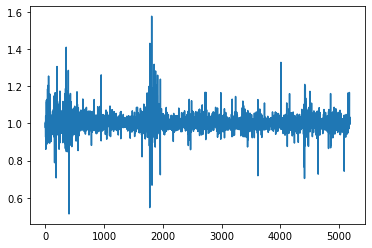

In [22]:
plt.plot(portfolio[0])

In [23]:
positions = 20

In [24]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [25]:
anas.naming

'date'

In [26]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,date,week,pv,daily_returns,adjclose,bench
5354,11463.342129,70.091713,14.664916,11.298838,359.599608,83.753271,3.447870,15.615447,2.400917,10.528506,...,3.253648,9.554224,549.828244,2023,2023-07-14,28,693.979326,0.994644,13737.045,4.908531
5355,11812.873735,66.793280,14.940413,11.601228,374.050287,85.495157,3.531158,15.817798,2.466647,10.593536,...,3.255915,9.714556,547.333462,2023,2023-07-17,29,712.813817,1.011472,13923.482,4.975149
5356,13781.686025,67.859390,16.206738,12.170085,393.755447,88.359685,3.513714,16.449519,2.507601,10.793826,...,3.239957,9.972884,546.845207,2023,2023-07-18,29,813.297567,1.035183,13923.482,4.975149
5357,13854.604998,68.184966,16.430988,12.109666,388.677091,87.501319,3.608276,15.648354,2.485714,10.772768,...,3.239481,9.727042,535.407746,2023,2023-07-19,29,816.627978,0.991197,13923.482,4.975149
5358,13840.817362,64.813225,16.430988,12.023353,396.169039,87.580410,3.540288,15.547324,2.426307,9.338104,...,3.261578,9.777892,519.047710,2023,2023-07-20,29,816.048758,0.988464,13923.482,4.975149
5359,14331.981369,64.744064,16.501311,11.694954,392.765606,88.456684,3.586035,16.154551,2.418030,9.412183,...,3.278791,9.542940,525.577971,2023,2023-07-21,29,841.487075,1.003771,13923.482,4.975149
5360,14247.462523,64.220591,16.616353,12.096542,395.951703,87.178431,3.472792,16.115421,2.436332,9.333742,...,3.283704,9.710344,530.732640,2023,2023-07-24,30,838.353765,1.004020,14210.546,5.077723
5361,14300.933629,62.834224,16.421658,11.931834,391.295081,87.754384,3.329669,16.040907,2.427791,9.386171,...,3.286616,9.916911,527.329425,2023,2023-07-25,30,841.121967,0.995430,14210.546,5.077723
5362,14255.957720,61.888954,16.065436,11.796568,382.500269,84.886225,3.265143,15.382153,2.384965,9.126745,...,3.206197,9.781313,518.012651,2023,2023-07-26,30,837.887991,0.982555,14210.546,5.077723
5363,14653.182548,63.081892,15.735821,11.855530,383.475798,84.848565,3.250444,15.538999,2.406857,9.178887,...,3.210255,9.891073,513.513528,2023,2023-07-27,30,857.448902,1.004191,14210.546,5.077723


In [27]:
cash_analysis = cumulative.copy()
cash_analysis["previous_day"] = cash_analysis["daily_returns"].shift(1)
cash_analysis["base"] = [min(row[1]["previous_day"],1) for row in cash_analysis.iterrows()]
cash_analysis["real_return"] = cash_analysis["base"] * cash_analysis["daily_returns"]
cash_analysis["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cash_analysis.iterrows()]
cash_analysis["running_cash"] = cash_analysis["cash"].cumsum()

In [28]:
cash_analysis["cash"].sum()

2548.984426235455

In [29]:
cash_analysis[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,1.003048,NaN,NaN,0.00000,0.000000
1,0.996449,1.000000,0.996449,0.00000,0.000000
2,0.991109,0.996449,0.987590,0.00000,0.000000
3,0.984298,0.991109,0.975547,0.00000,0.000000
4,1.003780,0.984298,0.988018,0.00000,0.000000
...,...,...,...,...,...
5359,1.003771,0.988464,0.992191,0.00000,2548.582446
5360,1.004020,1.000000,1.004020,0.40198,2548.984426
5361,0.995430,1.000000,0.995430,0.00000,2548.984426
5362,0.982555,0.995430,0.978065,0.00000,2548.984426


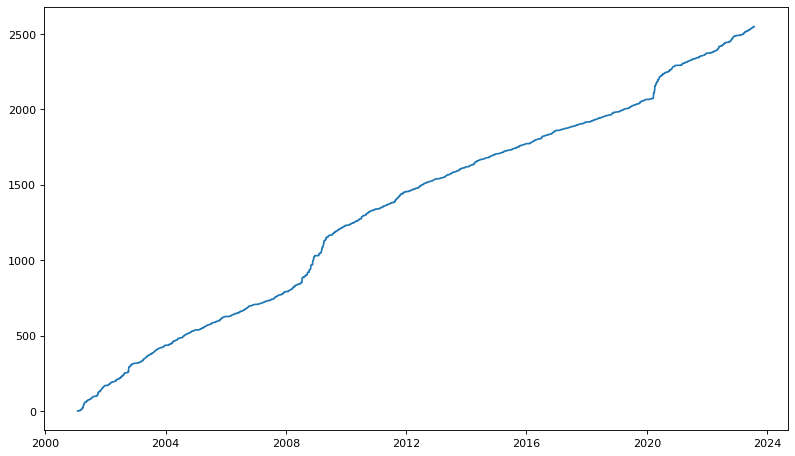

In [30]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cash_analysis["date"],cash_analysis["running_cash"])

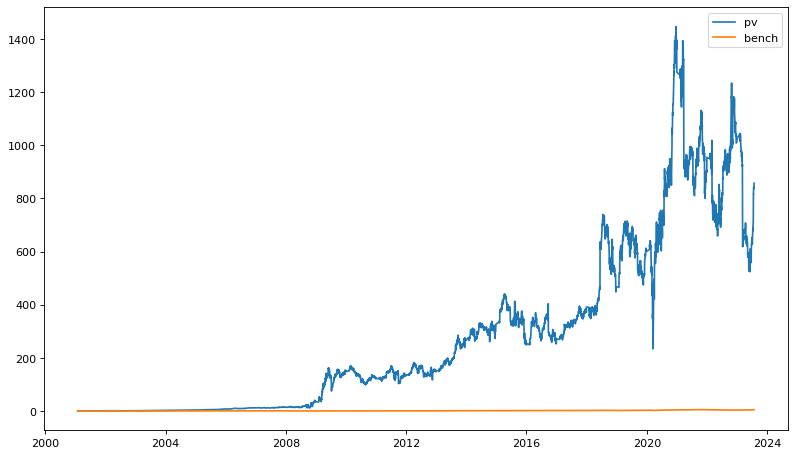

In [31]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [32]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,date,week,pv,daily_returns,adjclose,bench
0,1.005714,1.017747,0.997629,1.045981,1.028966,0.953846,1.000000,0.987383,1.002950,1.010118,...,0.988366,1.062222,0.994098,2001,2001-01-29,5,1.003048,1.003048,2798.606,1.000000
1,0.981991,0.958892,0.989159,1.035100,0.914056,0.950607,0.985545,1.090666,0.999618,0.999279,...,0.985193,1.082583,1.004444,2001,2001-01-30,5,0.999154,0.996449,2798.606,1.000000
2,0.985889,0.921524,1.011576,0.971714,0.869076,0.971173,1.008729,1.051419,1.029790,0.979633,...,0.979266,1.073561,1.032976,2001,2001-01-31,5,0.990087,0.991109,2798.606,1.000000
3,0.960725,0.856855,0.966366,0.955399,0.854010,1.022690,0.892647,1.028646,1.020607,1.014789,...,0.908861,1.048100,1.010262,2001,2001-02-01,5,0.974466,0.984298,2798.606,1.000000
4,0.890032,0.860431,0.903991,0.972656,0.871838,1.027515,0.898279,1.070527,1.062377,0.980503,...,0.903938,1.050439,1.050509,2001,2001-02-02,5,0.978296,1.003780,2798.606,1.000000
5,0.926079,0.891621,0.987099,1.009013,0.856283,1.019229,0.884459,1.098454,1.085553,0.956178,...,0.925997,1.089164,1.036362,2001,2001-02-05,6,0.991752,1.014232,2778.542,0.992831
6,0.797113,0.908897,0.965682,0.986150,0.858925,1.043718,0.862024,1.082286,1.038695,0.893714,...,0.928008,1.073909,0.995043,2001,2001-02-06,6,0.961477,0.969588,2778.542,0.992831
7,0.797113,0.889320,0.879688,1.007510,0.859171,1.074637,0.857387,1.001988,1.054326,0.918771,...,0.888368,1.067025,0.951228,2001,2001-02-07,6,0.952739,0.991899,2778.542,0.992831
8,0.797113,0.841778,0.869777,1.010100,0.835611,0.968628,0.835875,0.983128,1.015690,0.934673,...,0.798370,1.054928,0.916265,2001,2001-02-08,6,0.920401,0.966444,2778.542,0.992831
9,0.791330,0.859765,0.878398,1.039136,0.815536,0.922437,0.866580,1.011893,0.987101,0.945468,...,0.821690,1.058835,0.934560,2001,2001-02-09,6,0.924994,1.005195,2778.542,0.992831


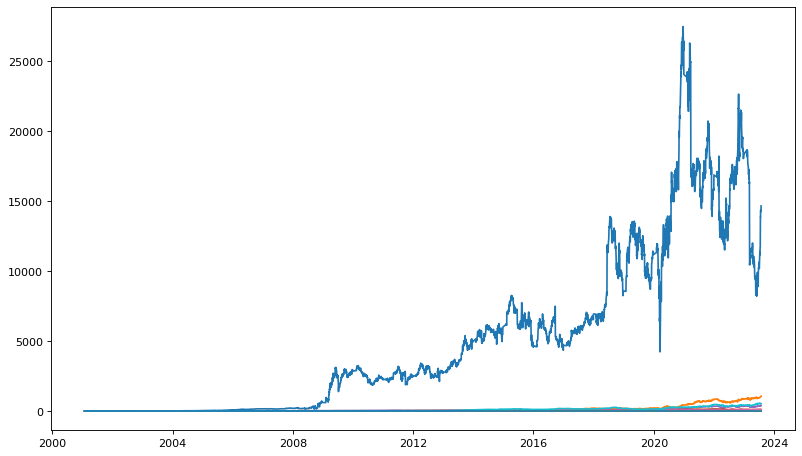

In [33]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
plt.show()


In [34]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,dately_delta,dately_delta_sign,actual_returns,position
GICS Sector,,,,,
Financials,2011.363022,0.064320,1.0,1.002207,10.049266
Information Technology,2010.970327,0.067430,1.0,1.001666,8.725677
Industrials,2011.526200,0.059095,1.0,1.001412,9.775301
Consumer Discretionary,2012.332863,0.064877,1.0,1.001393,8.891566
Materials,2012.535383,0.057054,1.0,1.001094,9.345161
Consumer Staples,2011.264350,0.040442,1.0,1.001035,9.923150
Energy,2013.219414,0.065322,1.0,1.000916,9.248867
Communication Services,2013.042242,0.063142,1.0,1.000906,8.691670
Health Care,2011.000629,0.057826,1.0,1.000767,8.935001


In [35]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

dately_delta  \
year date       ticker Security                                       
2008 2008-10-31 HIG    Hartford (The)                      1.525988   
2001 2001-04-06 EQIX   Equinix                             0.213592   
2008 2008-10-13 HBAN   Huntington National Bank            0.474966   
2004 2004-08-02 CMCSA  Comcast                             0.025912   
2009 2009-02-05 RF     Regions Financial Corporation       0.656000   
     2009-04-02 MGM    MGM Resorts                         0.174905   
2008 2008-11-21 CBRE   CBRE Group                          0.398844   
2020 2020-03-23 CZR    Caesars Entertainment               0.562358   
     2020-11-03 BIIB   Biogen                              0.025342   
2008 2008-09-18 AIG    American International Group        7.560976   
     2008-11-12 CBRE   CBRE Group                          0.344017   
2020 2020-03-23 NCLH   Norwegian Cruise Line Holdings      0.254587   
2008 2008-07-15 UAL    United Airlines Holdings            0.384840   
2020 2020-06-03 AAL    American Airlines Group             0.067736   
2002 2002-07-26 AES    AES Corporation                     0.711864   
2008 2008-07-16 HBAN   Huntington National Bank            0.193966   
2020 2020-04-03 CZR    Caesars Entertainment               0.418932   
2011 2011-02-09 IPGP   IPG Photonics                       0.027319   
2002 2002-10-09 NFLX   Netflix                             0.428571   
2020 2020-03-23 AAL    American Airlines Group             0.533719   
2006 2006-10-02 SWKS   Skyworks Solutions                  0.063584   
2008 2008-10-13 HIG    Hartford (The)                      0.606864   
2020 2020-03-18 OKE    Oneok                               0.672406   
2008 2008-09-29 AIG    American International Group        0.498413   
     2008-10-28 MGM    MGM Resorts                         0.433831   
2018 2018-06-12 ENPH   Enphase                             0.216450   
2009 2009-04-07 LNC    Lincoln Financial                   0.048589   
     2009-03-20 LNC    Lincoln Financial                   0.123134   
2001 2001-07-13 EQIX   Equinix                             0.019417   
2002 2002-09-26 EQIX   Equinix                             0.041667   

                                                       dately_delta_sign  \
year date       ticker Security                                            
2008 2008-10-31 HIG    Hartford (The)                                1.0   
2001 2001-04-06 EQIX   Equinix                                       1.0   
2008 2008-10-13 HBAN   Huntington National Bank                      1.0   
2004 2004-08-02 CMCSA  Comcast                                       1.0   
2009 2009-02-05 RF     Regions Financial Corporation                 1.0   
     2009-04-02 MGM    MGM Resorts                                   1.0   
2008 2008-11-21 CBRE   CBRE Group                                    1.0   
2020 2020-03-23 CZR    Caesars Entertainment                         1.0   
     2020-11-03 BIIB   Biogen                                        1.0   
2008 2008-09-18 AIG    American International Group                  1.0   
     2008-11-12 CBRE   CBRE Group                                    1.0   
2020 2020-03-23 NCLH   Norwegian Cruise Line Holdings                1.0   
2008 2008-07-15 UAL    United Airlines Holdings                      1.0   
2020 2020-06-03 AAL    American Airlines Group                       1.0   
2002 2002-07-26 AES    AES Corporation                               1.0   
2008 2008-07-16 HBAN   Huntington National Bank                      1.0   
2020 2020-04-03 CZR    Caesars Entertainment                         1.0   
2011 2011-02-09 IPGP   IPG Photonics                                 1.0   
2002 2002-10-09 NFLX   Netflix                                       1.0   
2020 2020-03-23 AAL    American Airlines Group                       1.0   
2006 2006-10-02 SWKS   Skyworks Solutions                            1.0   
2008 2008-10-13 HIG    Hartford (T

In [36]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,date,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2001,2001-01-29 00:00:00.000000000,0.983453,0.997220,1.000000,1.000000,0.987383,1.028966,1.014399,1.007157,0.988366,1.000000,1.000000
1,4004001,1720-02-06 09:03:13.464852480,0.949032,0.992606,1.014788,1.000000,0.984158,1.020966,1.056083,0.989304,0.989109,1.006889,1.000000
2,8012006001,1723-01-13 16:40:44.835356672,0.949831,0.976312,1.045418,0.991667,0.978237,1.026207,1.052493,0.964816,1.012376,1.006889,1.000000
3,16032024008001,1970-01-01 00:00:00.000000000,0.933883,0.908854,1.036096,1.035763,0.977656,1.025103,1.052493,0.924640,0.988366,1.006889,1.000000
4,32080080040010001,1970-01-01 00:00:00.000000000,0.950751,0.912647,1.032101,1.078153,0.980786,1.045451,1.059062,0.901544,0.988366,1.006889,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,0,1970-01-01 00:00:00.000000000,8.083575,383.245583,13.065651,9.989884,47.750458,19.221716,148.310943,82.601978,7.367425,0.362452,0.230012
5181,0,1970-01-01 00:00:00.000000000,8.009021,386.365736,13.164544,9.989884,47.364383,18.943951,148.463235,83.827912,7.427189,0.359432,0.230012
5182,0,1970-01-01 00:00:00.000000000,8.011524,388.768182,13.141666,9.989884,46.719462,19.096806,146.973556,82.186004,7.340164,0.359432,0.230012
5183,0,1970-01-01 00:00:00.000000000,7.911951,380.622218,12.800707,9.989884,45.467392,19.096806,145.997968,80.175002,7.197918,0.353081,0.230012
